<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_SGD_Fitting__TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting an HMM using Stochastic Gradient Descent

In this notebook, I fit the parameters $\boldsymbol\theta=(A, B, \pi)$ of an HMM by maximizing the log-likelihood:
\begin{align*}
\log \Pr(\mathbf y_{1}\cdots, \mathbf y_N|\boldsymbol \theta) = \sum_{n=1}^N\log \Pr(\mathbf y_n|\mathbf y_{1}\cdots \mathbf y_{n-1}, \boldsymbol \theta)
\end{align*}

This is simply the normalizing constant used in the Forwards step of an HMM state inference (see [HMM Inference](https://github.com/CorpuzKB/PML-Advance-Topics-notebooks/blob/3320e64f1b279aa079442f25d8bbc358e8d9a191/HMM_Inference__TensorFlow.ipynb)). Since for every filtered posterior from $1\cdots N$:
\begin{align*}
\boldsymbol\alpha_t&= \Pr(\mathbf z_t|\mathbf y_{1}\cdots \mathbf y_{t}, \boldsymbol\theta\\
&=\frac{\Pr(\mathbf z_t, \mathbf y_{1}\cdots \mathbf y_{t}|\boldsymbol\theta)}{\Pr(\mathbf y_n|\mathbf y_{1}\cdots \mathbf y_{n-1}, \boldsymbol \theta)}
\end{align*}

Note that parameter identifiability issues arise from label switching, and mitigating this problem is outside the scope of this notebook.
See [Baum-Welch](https://github.com/CorpuzKB/PML-Advance-Topics-notebooks/blob/3320e64f1b279aa079442f25d8bbc358e8d9a191/HMM_Baum_Welch_(EM)__TensorFlow.ipynb) for an alternative method of fitting the HMM parameters by obtaining sufficient statistics and maximizing them at every iteration.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

## HMM Inference Trainable TensorFlow Module

In [2]:
class HMM_Inference_TFM(tf.Module):
  def __init__(self, transition_distribution, emission_distribution, emission_params, initial_distribution, transformation_layer, **kwargs):
    super().__init__(**kwargs)
    self.transition_distribution = tf.Variable(transition_distribution, dtype=tf.float32, name='transition_matrix')
    self.emission_params = tf.Variable(emission_params, dtype=tf.float32, name='emission_params')
    self.initial_distribution = tf.Variable(initial_distribution, dtype=tf.float32, name='initial_distribution')
    self.emission_distribution = emission_distribution
    self.transformation_layer = transformation_layer

  def __call__(self, observations):
    return self.Forward(*self.transformation_layer(
        self.transition_distribution, 
        self.emission_distribution, 
        self.emission_params, 
        self.initial_distribution))

  def normalizing_constant(self, x):
    return tf.reduce_sum(x, -2, keepdims=True)

  @tf.function
  def Forward(self, transition_distribution, initial_distribution, local_evidence):
    filtered_Z = tf.TensorArray(local_evidence.dtype, size=0, dynamic_size=True)
    filtered_t = tf.broadcast_to(initial_distribution, local_evidence[:, 0].shape)
    filtered_Z_t = self.normalizing_constant(filtered_t)
    filtered_t = filtered_t / filtered_Z_t
    for i in tf.range(num_steps):
      filtered_t = local_evidence[:, i] * (tf.transpose(transition_distribution) @ filtered_t)
      filtered_Z_t = self.normalizing_constant(filtered_t)
      filtered_t = filtered_t / filtered_Z_t
      filtered_Z = filtered_Z.write(i, filtered_Z_t)
    return tf.transpose(filtered_Z.stack(), [1, 0, 2, 3])

## Parameter Transformation Layers

In [5]:
class HMM_Categorical_Layer(tf.keras.layers.Layer):
    def __init__(self):
      super().__init__()

    def call(self, transition_distribution, emission_distribution, emission_params, initial_distribution):
      transition_distribution = tf.nn.softmax(transition_distribution)
      emission_model = emission_distribution(tf.nn.softmax(emission_params))
      local_evidence = tf.exp(emission_model.log_prob(observations))[..., tf.newaxis]
      initial_distribution = tf.nn.softmax(initial_distribution, axis=0)
      return transition_distribution, initial_distribution, local_evidence

class HMM_Gaussian1D_Layer(tf.keras.layers.Layer):
    def __init__(self):
      super().__init__()

    def call(self, transition_distribution, emission_distribution, emission_params, initial_distribution):
      transition_distribution = tf.nn.softmax(transition_distribution)
      emission_mean = emission_params[0]
      emission_cov = emission_params[1]*emission_params[1]
      emission_model = emission_distribution([emission_mean, emission_cov])
      local_evidence = tf.exp(emission_model.log_prob(observations))[..., tf.newaxis]
      initial_distribution = tf.nn.softmax(initial_distribution, axis=0)
      return transition_distribution, initial_distribution, local_evidence

## SGD Loss Function and Training Routine

In [31]:
@tf.function
def SGD_step(inference_module, inference_loss, observations):
  with tf.GradientTape() as tape:
    loss = inference_loss(inference_module, observations)
  grads = tape.gradient(loss, inference_module.trainable_variables)
  return grads, loss

def HMM_Negative_Log_Likelihood(inference_module, observations):
  return -tf.reduce_sum(tf.math.log(inference_module(observations)))

def HMM_SGD(inference_module, inference_loss, observations, optimizer, iterations=1):
  loss = []
  for i in tf.range(iterations):
    grads, HMM_NLL = SGD_step(inference_module, inference_loss, observations)
    optimizer.apply_gradients(zip(grads, inference_module.trainable_variables))
    loss.append(HMM_NLL)
    tf.print("Iteration: ", i + 1, '\tNLL = ', HMM_NLL)
  return loss

## HMM Observations Generator

In [4]:
@tf.function
def HMM_Generator(transition_matrix, emission_distribution, emission_params, states_probs_0, steps, batch_dims=1):
  state_t = tfd.Categorical(probs=tf.squeeze(states_probs_0)).sample([batch_dims, 1])
  transition_distribution = tfd.Categorical(probs=transition_matrix).sample([batch_dims, steps])
  observation_distribution = emission_distribution(emission_params).sample([batch_dims, steps])
  state = tf.TensorArray(state_t.dtype, size=0, dynamic_size=True)
  obs = tf.TensorArray(observation_distribution.dtype, size=0, dynamic_size=True, clear_after_read=False)
  for i in tf.range(steps):
    state_t = tf.gather_nd(transition_distribution[:, i], state_t, 1)[:, tf.newaxis]
    obs_t = tf.gather_nd(observation_distribution[:, i], state_t, 1)[:, tf.newaxis]
    state = state.write(i, state_t)
    obs = obs.write(i, obs_t)
  obs_correct_dims = tf.concat([tf.constant([1, 0]), tf.range(2, tf.size(obs_t.shape) + 1)], 0)
  return tf.transpose(state.stack(), [1, 0, 2]), tf.transpose(obs.stack(), obs_correct_dims)

# Example 1. Casino HMM Parameter Learning Using SGD

## Set the ground-truth parameters $(A_g, B_g, \pi_g)$

In [7]:
num_states = 2

initial_distribution = tf.constant([
    [0.5],
    [0.5]
])

transition_distribution = tf.constant([
    [0.95, 0.05], 
    [0.10, 0.90]
])

emission_params = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])

emission_distribution =  tf.keras.layers.Lambda(lambda arg: tfd.Categorical(probs=arg))

tf.print('Transition Distribution:\n{}\n\nEmission Distribution\n{}\n\nEmission Parameters\n{}'.format(
    transition_distribution, emission_distribution(emission_params), emission_params))

Transition Distribution:
[[0.95 0.05]
 [0.1  0.9 ]]

Emission Distribution
tfp.distributions.Categorical("Categorical", batch_shape=[2], event_shape=[], dtype=int32)

Emission Parameters
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]


## Generate Sample Data

In [8]:
num_batches = 10
num_steps = 5000
true_states, observations = HMM_Generator(transition_distribution, emission_distribution, emission_params, initial_distribution, num_steps, num_batches)
print('Generated {} batches of {}-step Casino HMM samples'.format(num_batches, num_steps), '\n')

Generated 10 batches of 5000-step Casino HMM samples 



## Start the training routine

In [ ]:
transition_distribution_init = tf.constant([
    [0.5, 0.5],
    [0.5, 0.5]])

emission_params_init = tf.constant([
    [0.2, 0.1, 0.2, 0.3, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.2, 0.3, 0.2]])

initial_distribution_init = tf.constant([
    [0.5],
    [0.5]])

inference_module = HMM_Inference_TFM(transition_distribution_init, emission_distribution, emission_params_init, initial_distribution_init, HMM_Categorical_Layer())
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
num_iter = 250
HMM_loss = HMM_SGD(inference_module, HMM_Negative_Log_Likelihood, observations, optimizer, iterations=num_iter)

## Results

True parameters
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]

[[0.5]
 [0.5]]

[[0.95 0.05]
 [0.1  0.9 ]] 

Trained parameters
[[0.1  0.1  0.1  0.11 0.1  0.49]
 [0.17 0.17 0.17 0.17 0.17 0.16]] 

[[0.54]
 [0.46]] 

[[0.9  0.1 ]
 [0.05 0.95]] 



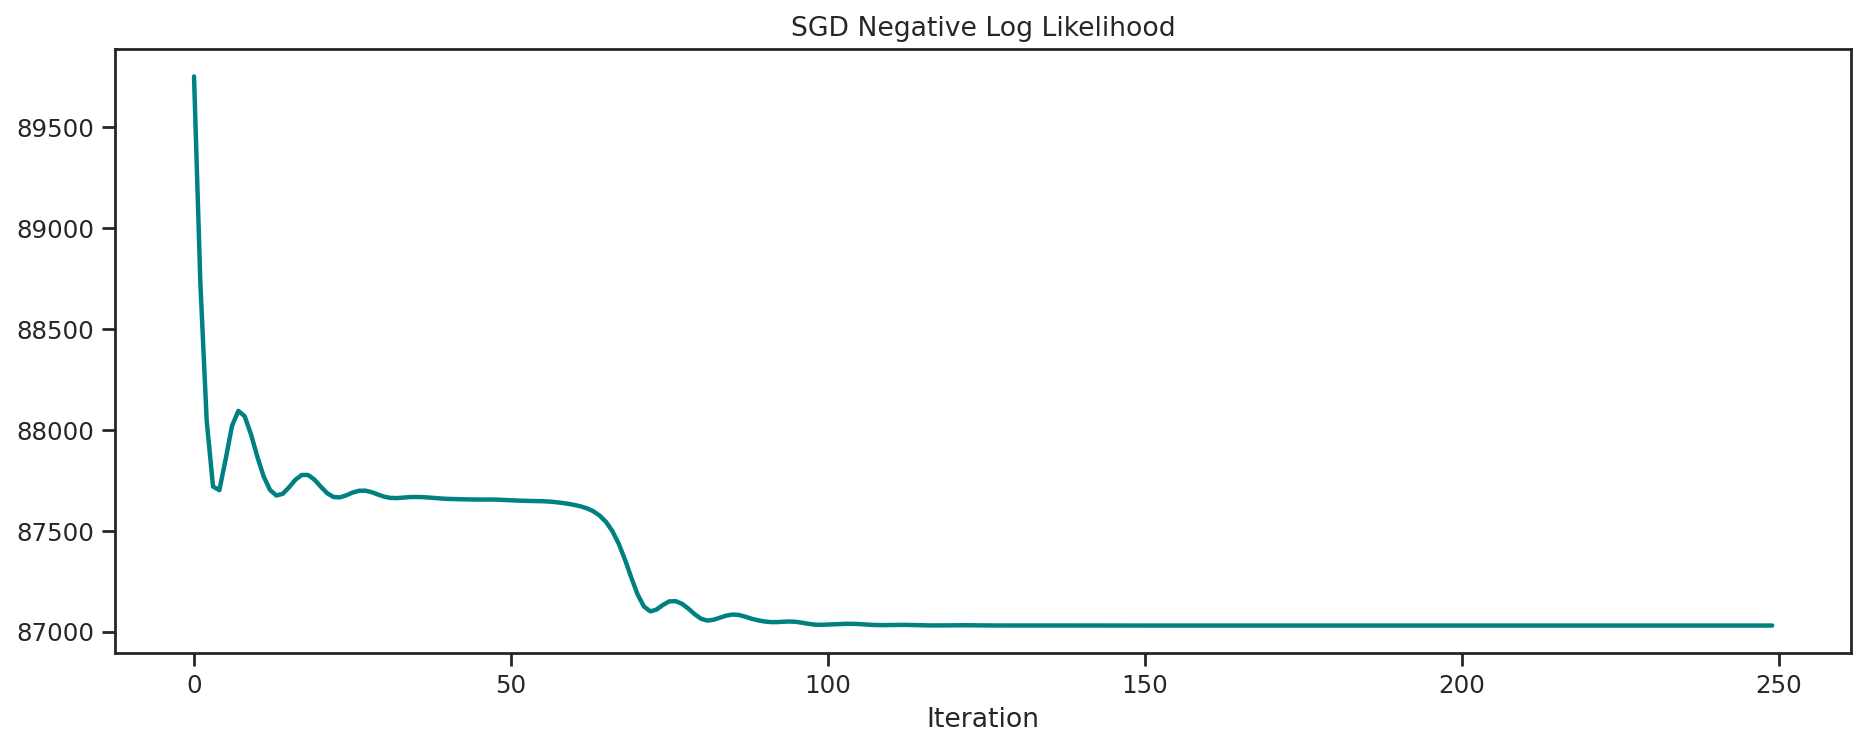

In [13]:
tf.print('True parameters\n{}\n\n{}\n\n{}'.format(emission_params, initial_distribution, transition_distribution), '\n\nTrained parameters')
SGD_trained = [tf.nn.softmax(inference_module.trainable_variables[0]).numpy(),
              tf.nn.softmax(inference_module.trainable_variables[1], axis=0).numpy(),
              tf.nn.softmax(inference_module.trainable_variables[2]).numpy()]

for params in SGD_trained:
  print(np.round(params, 2), '\n')

plt.figure(figsize=(14, 5))
plt.plot(HMM_loss, color="teal", linewidth=2)
plt.title("SGD Negative Log Likelihood"); plt.xlabel('Iteration'); plt.show()

# Example 2. Gaussian HMM Parameter Learning (under construction)

## Generate Sample Dataset from $\boldsymbol \theta = (A_g, B_g, \pi_g)$

In [15]:
num_batches = 5
num_steps = 5000
num_states = 3
initial_distribution = tf.fill([num_states, 1], 1/num_states)

transition_distribution = tf.constant([
    [0.90, 0.05, 0.025], 
    [0.05, 0.925, 0.025],
    [0.025, 0.025, 0.95]])

emission_params = tf.constant([
    [1.0, 3.0, 5.0],
    [2.6, 1.2, 0.71]])

emission_distribution =  tf.keras.layers.Lambda(lambda arg: tfd.Normal(loc=arg[0], scale=arg[1]))

true_states, observations = HMM_Generator(transition_distribution, emission_distribution, emission_params, initial_distribution, num_steps, num_batches)
tf.print('Transition Distribution:\n{}\n\nEmission Distribution\n{}\n\nEmission Parameters\n{}'.format(
    transition_distribution, emission_distribution(emission_params), emission_params))
print('\nGenerated {} batches of {}-step Casino HMM samples'.format(num_batches, num_steps), '\n')

Transition Distribution:
[[0.9   0.05  0.025]
 [0.05  0.925 0.025]
 [0.025 0.025 0.95 ]]

Emission Distribution
tfp.distributions.Normal("Normal", batch_shape=[3], event_shape=[], dtype=float32)

Emission Parameters
[[1.   3.   5.  ]
 [2.6  1.2  0.71]]

Generated 5 batches of 5000-step Casino HMM samples 



## Start the training routine

In [ ]:
transition_distribution_init = tf.constant([
    [0.4, 0.3, 0.3], 
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3]])

emission_params_init = tf.constant([
    [1.0, 2.0, 3.0],
    [1.0, 1.0, 1.0]])

initial_distribution_init = tf.constant([
    [0.3],
    [0.4],
    [0.3]])

inference_module = HMM_Inference_TFM(transition_distribution_init, emission_distribution, emission_params_init, initial_distribution_init, HMM_Gaussian1D_Layer())
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
num_iter = 300
HMM_loss = HMM_SGD(inference_module, HMM_Negative_Log_Likelihood, observations, optimizer, iterations=num_iter)

## Results

True parameters
[[1.   3.   5.  ]
 [2.6  1.2  0.71]]

[[0.33333334]
 [0.33333334]
 [0.33333334]]

[[0.9   0.05  0.025]
 [0.05  0.925 0.025]
 [0.025 0.025 0.95 ]] 

Trained parameters
[[1.06 2.98 4.98]
 [2.58 1.23 0.71]] 

[[0.56]
 [0.44]
 [0.  ]] 

[[0.93 0.05 0.03]
 [0.05 0.92 0.03]
 [0.05 0.   0.95]] 



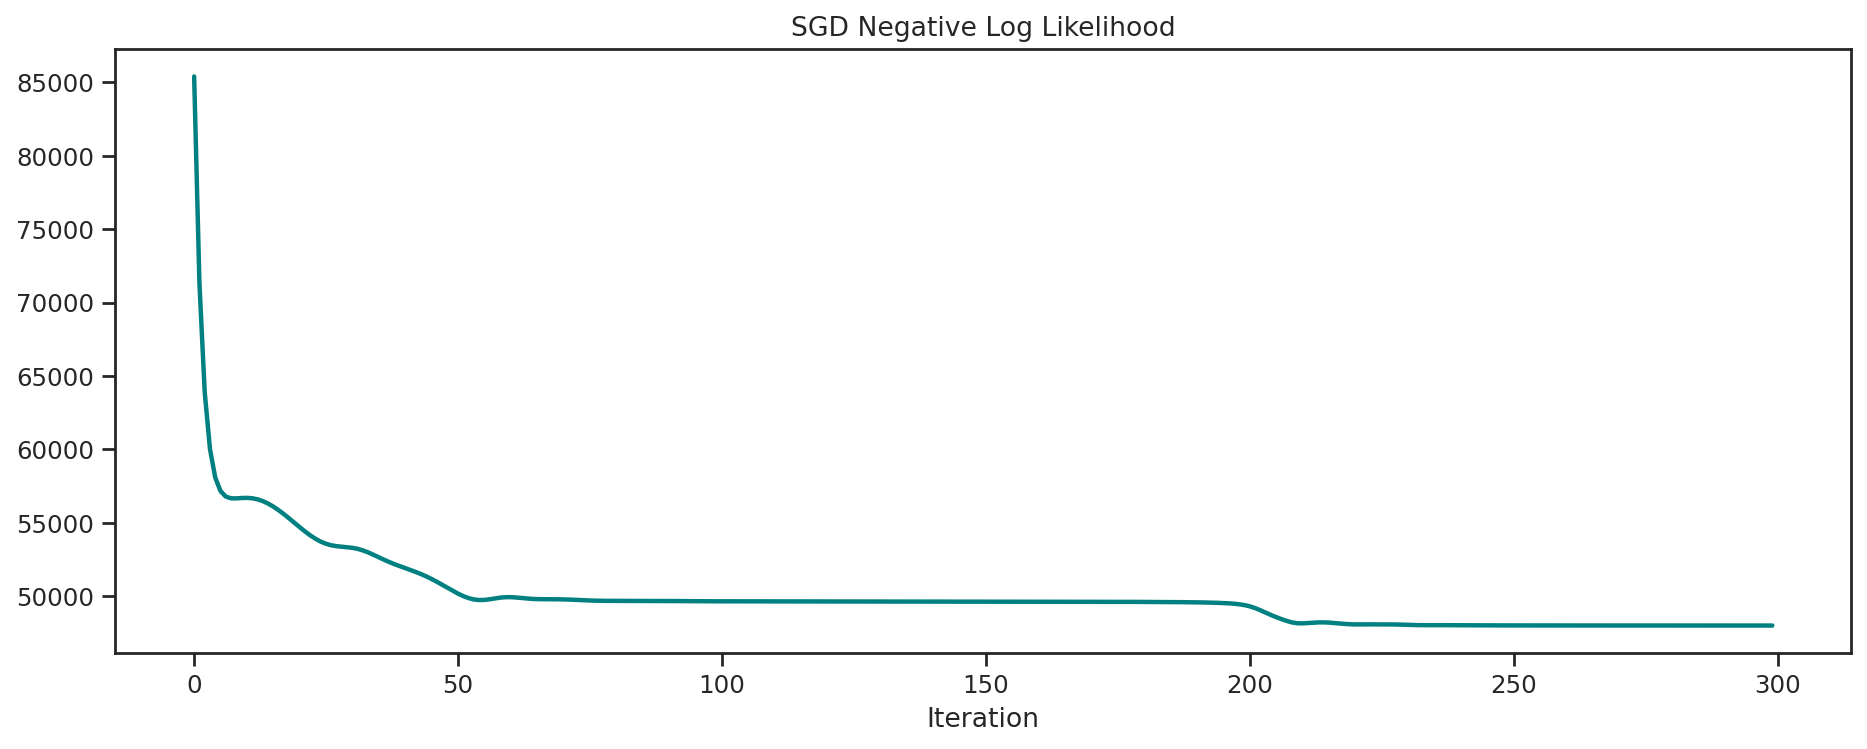

In [43]:
tf.print('True parameters\n{}\n\n{}\n\n{}'.format(emission_params, initial_distribution, transition_distribution), '\n\nTrained parameters')
SGD_trained = [tf.stack([inference_module.trainable_variables[0][0].numpy(),
                         tf.math.pow(inference_module.trainable_variables[0][1], 2).numpy()]),
              tf.nn.softmax(inference_module.trainable_variables[1], axis=0).numpy(),
              tf.nn.softmax(inference_module.trainable_variables[2]).numpy()]

for params in SGD_trained:
  print(np.round(params, 2), '\n')

plt.figure(figsize=(14, 5))
plt.plot(HMM_loss, color="teal", linewidth=2)
plt.title("SGD Negative Log Likelihood"); plt.xlabel('Iteration'); plt.show()